# Neural Architecture search (NAS) algorithms

## Why NAS
* NN are still hard to design - thus requre expert knowledge and it is time consuming (tuning the network)

# What is NAS
* it is technique for $\color{green}{\text{automating}}$ the design of ANNs, especially in some complex NN designs
* Neural Architecture Search, a gradient-based method for finding good architectures

This notebook demonstrates a minimal example of NAS for automatically discovering
a neural network architecture. We compare it to a manually-designed model whose
hyperparameters are chosen by a human.

**Goal:** Show the advantage of NAS — automating architecture discovery and
reducing human bias in model design.

We will:

1. Train a **human-designed MLP** on MNIST-like data.
2. Use a **simple NAS algorithm (RL controller)** that:
   - Samples neural network architectures  
   - Trains each  
   - Gets a validation reward  
   - Improves its sampling policy  
3. Compare both approaches.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


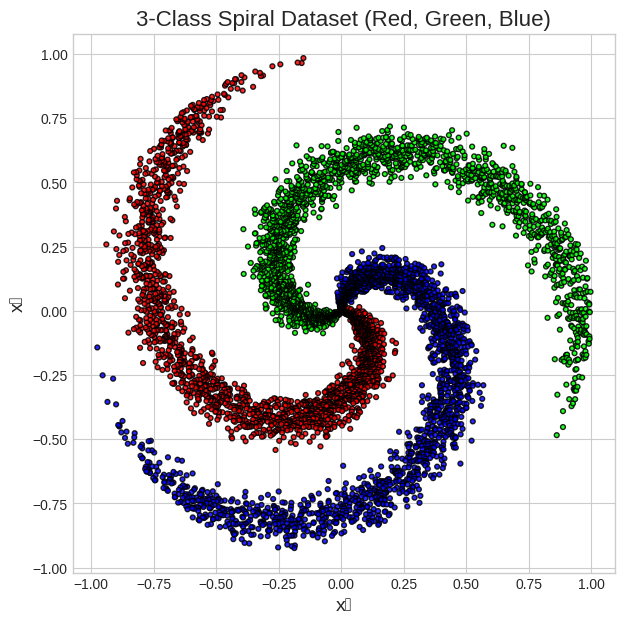

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score

plt.style.use("seaborn-v0_8-whitegrid")

np.random.seed(123456)
# -----------------------------
# Generate 3-class Spiral Dataset
# -----------------------------
def generate_spiral(n_points, n_classes=3):
    X = np.zeros((n_points*n_classes, 2))
    y = np.zeros(n_points*n_classes, dtype='int')

    for j in range(n_classes):
        ix = range(n_points*j, n_points*(j+1))
        r = np.linspace(0.0, 1, n_points)
        t = np.linspace(j*4, (j+1)*4, n_points) + np.random.randn(n_points)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    return X, y

N = 2000
X_np, y_np = generate_spiral(N)
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long)

dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

X[:5], y[:5]
# Define colors for classes 0,1,2
color_map = np.array([
    [0.0, 0.0, 1.0],    # blue

    [0.0, 1.0, 0.0],   # green
    [1.0, 0.0, 0.0]   # red

])

plt.figure(figsize=(7,7))

plt.scatter(
    X_np[:,0],
    X_np[:,1],
    c=color_map[y_np],
    s=12,
    edgecolor="k",
    alpha=0.85
)

plt.title("3-Class Spiral Dataset (Red, Green, Blue)", fontsize=16)
plt.xlabel("x₁", fontsize=14)
plt.ylabel("x₂", fontsize=14)
plt.grid(True)
plt.show()


In [ ]:
class HumanMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Too shallow and too small → performs badly
        self.layers = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )

    def forward(self, x):
        return self.layers(x)

def train_classifier(model, epochs=25, lr=1e-3):
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for xb, yb in train_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

    with torch.no_grad():
        pred_all = model(X).argmax(dim=1)
        acc = accuracy_score(y.numpy(), pred_all.numpy())

    return pred_all, acc

In [ ]:
class NASController(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(input_size=10, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 7)

    def forward(self):
        x = torch.randn(1, 1, 10)
        _, h = self.rnn(x)
        logits = self.fc(h.squeeze()).squeeze()

        layer_logits, hidden_logits, activation_logits = torch.split(logits, [2, 3, 2])

        # sample instead of argmax
        layer_dist = torch.distributions.Categorical(logits=layer_logits)
        hidden_dist = torch.distributions.Categorical(logits=hidden_logits)
        act_dist = torch.distributions.Categorical(logits=activation_logits)

        L = layer_dist.sample() + 1
        H = [4,8,16,32,64][hidden_dist.sample().item()]
        A = ["relu", "tanh"][act_dist.sample().item()]

        return (L.item(), H, A), (layer_dist, hidden_dist, act_dist)

In [ ]:
def build_nas_model(L, H, A):
    act = nn.ReLU() if A == "relu" else nn.Tanh()
    layers = [nn.Linear(2, H), act]

    for _ in range(L - 1):
        layers.append(nn.Linear(H, H))
        layers.append(act)

    layers.append(nn.Linear(H, 3))
    return nn.Sequential(*layers)

In [ ]:
controller = NASController()
opt_ctrl = optim.Adam(controller.parameters(), lr=1e-3)



def nas_search(iterations=40):
    best_acc = -1
    best_arch = None
    best_pred = None


    acc_list = []
    archlist = []
    for i in range(iterations):
        (L, H, A), (layer_dist, hidden_dist, act_dist) = controller()

        model = build_nas_model(L, H, A)
        _, acc = train_classifier(model, epochs=15)

        # REINFORCE loss
        log_prob = (layer_dist.log_prob(torch.tensor(L-1)) +
                    hidden_dist.log_prob(torch.tensor([4,8,16,32,64].index(H))) +
                    act_dist.log_prob(torch.tensor(["relu","tanh"].index(A))))

        reward = torch.tensor(acc)
        loss = -reward * log_prob

        opt_ctrl.zero_grad()
        loss.backward()
        opt_ctrl.step()

        print(f"Iter {i}: acc={acc:.4f}  ->  L={L}, H={H}, A={A}")

        if acc > best_acc:
            best_acc = acc
            best_arch = (L, H, A)
            best_pred = None

    return best_pred, best_acc, best_arch,acc_list, archlist


In [ ]:
# Human model
human_model = HumanMLP()
pred_human, acc_human = train_classifier(human_model)
print("Human Accuracy:", acc_human)

# NAS model
pred_nas, acc_nas, nas_arch, acc_l, arch_l = nas_search()
print("NAS Best Architecture:", nas_arch)
print("NAS Accuracy:", acc_nas)

Human Accuracy: 0.7248333333333333
Iter 0: acc=0.6315  ->  L=2, H=16, A=tanh
Iter 1: acc=0.5335  ->  L=1, H=8, A=tanh
Iter 2: acc=0.5363  ->  L=1, H=16, A=tanh
Iter 3: acc=0.5273  ->  L=1, H=4, A=tanh
Iter 4: acc=0.5328  ->  L=1, H=16, A=tanh
Iter 5: acc=0.5270  ->  L=1, H=4, A=relu
Iter 6: acc=0.9180  ->  L=2, H=16, A=relu
Iter 7: acc=0.5232  ->  L=1, H=8, A=tanh
Iter 8: acc=0.5498  ->  L=2, H=4, A=tanh
Iter 9: acc=0.6253  ->  L=1, H=16, A=relu
Iter 10: acc=0.5353  ->  L=2, H=4, A=tanh
Iter 11: acc=0.5368  ->  L=1, H=16, A=tanh
Iter 12: acc=0.5475  ->  L=1, H=4, A=tanh
Iter 13: acc=0.5502  ->  L=2, H=4, A=tanh
Iter 14: acc=0.5387  ->  L=2, H=4, A=relu
Iter 15: acc=0.5340  ->  L=1, H=16, A=tanh
Iter 16: acc=0.6272  ->  L=2, H=4, A=relu
Iter 17: acc=0.5067  ->  L=2, H=4, A=relu
Iter 18: acc=0.5325  ->  L=2, H=4, A=relu
Iter 19: acc=0.5380  ->  L=1, H=16, A=tanh
Iter 20: acc=0.5810  ->  L=1, H=4, A=relu
Iter 21: acc=0.5292  ->  L=1, H=4, A=tanh
Iter 22: acc=0.5972  ->  L=2, H=8, A=relu
I

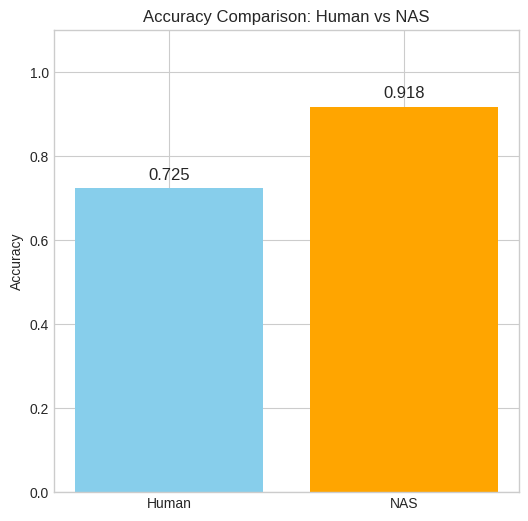

In [ ]:
def plot_accuracy_comparison(acc_human, acc_nas):
    plt.figure(figsize=(6,6))
    plt.bar(["Human", "NAS"], [acc_human, acc_nas], color=["skyblue", "orange"])

    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison: Human vs NAS")
    plt.ylim(0, 1)

    for i, v in enumerate([acc_human, acc_nas]):
        plt.ylim(0, 1.1)
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=12)

    plt.show()

plot_accuracy_comparison(acc_human, acc_nas)

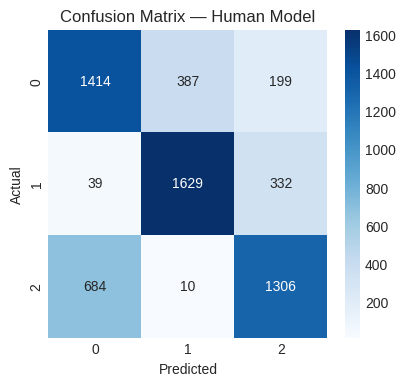

AttributeError: 'NoneType' object has no attribute 'numpy'

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion_plot(y_true, pred, title):
    cm = confusion_matrix(y_true, pred)

    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

confusion_plot(y_np, pred_human.numpy(), "Confusion Matrix — Human Model")
confusion_plot(y_np, pred_nas.numpy(),   "Confusion Matrix — NAS Model")

In [ ]:
from copy import deepcopy

def nas_search_record(iterations=12):
    snapshots = []   # store model + metadata per iteration

    best_acc = -1
    best_arch = None
    best_model = None

    for i in range(iterations):
        L, H, A = controller()
        model = build_nas_model(L, H, A)

        pred, acc = train_classifier(model, epochs=20, lr=1e-3)

        snapshots.append({
            "model": deepcopy(model).cpu(),
            "acc": acc,
            "arch": (L, H, A)
        })

        # RL update
        loss = -torch.tensor(acc, requires_grad=True)
        opt_ctrl.zero_grad()
        loss.backward()
        opt_ctrl.step()

        if acc > best_acc:
            best_acc = acc
            best_arch = (L, H, A)
            best_model = deepcopy(model)

        print(f"NAS iter {i}: acc={acc:.3f} arch={L, H, A}")

    return snapshots, best_model, best_arch


In [ ]:
import plotly.graph_objects as go
import numpy as np
import torch


def pretty_architecture_string(L, H, A):
    """Build readable architecture diagram."""
    act = "ReLU" if A == "relu" else "Tanh"
    txt = "Input(2)\n"
    txt += f"Linear(2 → {H}) → {act}\n"
    for _ in range(L - 1):
        txt += f"Linear({H} → {H}) → {act}\n"
    txt += f"Linear({H} → 3) (Output)"
    return txt


def plotly_nas_boundary_with_handmade_and_best(snapshots, X_np, y_np, human_model):

    # Create meshgrid for predictions
    h = 0.03
    x_min, x_max = X_np[:,0].min() - 0.5, X_np[:,0].max() + 0.5
    y_min, y_max = X_np[:,1].min() - 0.5, X_np[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # Find best NAS result
    accuracies = [snap['acc'] for snap in snapshots]
    best_idx = int(np.argmax(accuracies))
    best_acc = accuracies[best_idx]
    best_arch = snapshots[best_idx]["arch"]

    # ------------------------------------------------------
    # Build NAS animation frames
    # ------------------------------------------------------
    frames = []
    for i, snap in enumerate(snapshots):
        model = snap["model"]
        acc = snap["acc"]
        arch = snap["arch"]
        L, H, A = arch

        # Predict decision boundary
        Z = model(grid)
        Z = torch.argmax(Z, dim=1).numpy().reshape(xx.shape)

        # Architecture text
        arch_text = pretty_architecture_string(L, H, A)

        # If BEST → green border and “BEST MODEL ⭐” banner
        if i == best_idx:
            box_color = "lightgreen"
            highlight_banner = "<br><b style='color:green; font-size:18px;'>⭐ BEST MODEL ⭐</b>"
        else:
            box_color = "white"
            highlight_banner = ""

        annotation = (
            f"<b>Iteration:</b> {i}<br>"
            f"<b>NAS Accuracy:</b> {acc:.3f}<br>"
            f"<b>Architecture:</b> {arch}<br>"
            f"<b>Best NAS:</b> {best_acc:.3f} (Iter {best_idx})"
            f"{highlight_banner}<br><br>"
            f"<b>Network:</b><pre>{arch_text}</pre>"
        )

        frames.append(
            go.Frame(
                data=[
                    go.Contour(
                        x=xx[0], y=yy[:,0], z=Z,
                        colorscale="RdBu",
                        showscale=False,
                        opacity=0.55
                    ),
                    go.Scatter(
                        x=X_np[:,0], y=X_np[:,1],
                        mode="markers",
                        marker=dict(
                            color=y_np, colorscale="RdBu",
                            size=6,
                            line=dict(color='black', width=0.3)
                        )
                    )
                ],
                name=f"Iter {i}",
                layout=go.Layout(
                    annotations=[
                        go.layout.Annotation(
                            text=annotation,
                            x=0.02, y=0.98,
                            xref="paper", yref="paper",
                            showarrow=False,
                            align="left",
                            bgcolor=box_color,             # ⭐ green if best
                            bordercolor="green" if i == best_idx else "black",
                            borderwidth=3 if i == best_idx else 1,
                            font=dict(size=12),
                        )
                    ]
                )
            )
        )

    # ------------------------------------------------------
    # Add HUMAN MODEL as a frame (position = #10)
    # ------------------------------------------------------
    Z_hm = human_model(grid)
    Z_hm = torch.argmax(Z_hm, dim=1).numpy().reshape(xx.shape)

    from sklearn.metrics import accuracy_score
    human_pred = human_model(torch.tensor(X_np, dtype=torch.float32)).argmax(dim=1)
    human_acc = accuracy_score(y_np, human_pred.numpy())

    arch_human_text = (
        "Input(2)\n"
        "Linear(2 → 16) → ReLU\n"
        "Linear(16 → 8) → ReLU\n"
        "Linear(8 → 3) (Output)"
    )

    annotation_human = (
        f"<b>Hand-Made Baseline Model</b><br>"
        f"<b>Accuracy:</b> {human_acc:.3f}<br>"
        f"<b>Architecture:</b> (2→16→8→3)<br><br>"
        f"<pre>{arch_human_text}</pre>"
    )

    human_frame_index = 10 if len(frames) > 10 else len(frames)
    frames.insert(
        human_frame_index,
        go.Frame(
            data=[
                go.Contour(
                    x=xx[0], y=yy[:,0], z=Z_hm,
                    colorscale="RdBu",
                    showscale=False,
                    opacity=0.55
                ),
                go.Scatter(
                    x=X_np[:,0], y=X_np[:,1],
                    mode="markers",
                    marker=dict(
                        color=y_np, colorscale="RdBu",
                        size=6,
                        line=dict(color='black', width=0.3)
                    )
                )
            ],
            name="Human Model",
            layout=go.Layout(
                annotations=[
                    go.layout.Annotation(
                        text=annotation_human,
                        x=0.02, y=0.98,
                        xref="paper", yref="paper",
                        showarrow=False,
                        align="left",
                        bgcolor="white",
                        bordercolor="black",
                        borderwidth=2
                    )
                ]
            )
        )
    )

    # ------------------------------------------------------
    # Build slider steps (with best model ⭐)
    # ------------------------------------------------------
    slider_steps = []
    for i, f in enumerate(frames):
        label = f"Iter {i}"

        if f.name == "Human Model":
            label = "Human Model (Baseline)"

        if i == best_idx:
            label += " ⭐"

        slider_steps.append(
            dict(
                method="animate",
                label=label,
                args=[[f.name], dict(frame=dict(duration=0, redraw=True))]
            )
        )

    # Build final figure
    fig = go.Figure(
        data=frames[0].data,
        frames=frames
    )

    fig.update_layout(
        title=f"NAS Decision Boundary Evolution (⭐ Best at Iter {best_idx}, Acc={best_acc:.3f})",
        height=900,
        width=850,
        annotations=frames[0].layout.annotations,

        updatemenus=[{
            "type": "buttons",
            "x": 0.1, "y": -0.1,
            "buttons": [
                {
                    "label": "▶ Play",
                    "method": "animate",
                    "args":[None, dict(
                        frame=dict(duration=1500, redraw=True),
                        transition=dict(duration=400),
                        fromcurrent=True
                    )]
                },
                {
                    "label": "⏸ Pause",
                    "method": "animate",
                    "args":[[None], dict(frame=dict(duration=0, redraw=False))]
                }
            ]
        }],

        sliders=[{
            "active": 0,
            "pad": {"t": 60},
            "steps": slider_steps
        }]
    )

    fig.show()


In [ ]:
snapshots, best_model, best_arch = nas_search_record(iterations=20)


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
plotly_nas_boundary_with_handmade_and_best(snapshots, X_np, y_np, human_model)


NameError: name 'snapshots' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

np.random.seed(12345)
torch.manual_seed(12345)

# -----------------------------
# Spiral dataset
# -----------------------------

def generate_spiral(n_points, n_classes=3):
    X = np.zeros((n_points*n_classes, 2))
    y = np.zeros(n_points*n_classes, dtype='int')

    for j in range(n_classes):
        ix = range(n_points*j, n_points*(j+1))
        r = np.linspace(0.0, 1, n_points)
        t = np.linspace(j*4, (j+1)*4, n_points) + np.random.randn(n_points)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    return X, y

N = 2000
X_np, y_np = generate_spiral(N)
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long)

dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

# -----------------------------
# Human baseline MLP
# -----------------------------

class HumanMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )

    def forward(self, x):
        return self.layers(x)

def train_classifier(model, epochs=15, lr=1e-3):
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(epochs):
        for xb, yb in train_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

    with torch.no_grad():
        preds = model(X).argmax(dim=1)
        acc = accuracy_score(y.numpy(), preds.numpy())

    return preds, acc

# -----------------------------
# NAS Controller (REINFORCE)
# -----------------------------

HIDDEN_OPTIONS = [8, 16, 32, 64, 128]
ACT_OPTIONS = ["relu", "tanh"]

class NASController(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(input_size=10, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 2 + len(HIDDEN_OPTIONS) + len(ACT_OPTIONS))

    def forward(self):
        # random probe input
        x = torch.randn(1, 1, 10)
        _, h = self.rnn(x)
        logits = self.fc(h.squeeze())

        # split logits
        layer_logits, hidden_logits, act_logits = torch.split(
            logits, [2, len(HIDDEN_OPTIONS), len(ACT_OPTIONS)]
        )

        # make distributions
        layer_dist = torch.distributions.Categorical(logits=layer_logits)
        hidden_dist = torch.distributions.Categorical(logits=hidden_logits)
        act_dist = torch.distributions.Categorical(logits=act_logits)

        # sample architecture
        L = layer_dist.sample().item() + 1
        H = HIDDEN_OPTIONS[hidden_dist.sample().item()]
        A = ACT_OPTIONS[act_dist.sample().item()]

        return (L, H, A), (layer_dist, hidden_dist, act_dist)

# -----------------------------
# Build sampled architecture
# -----------------------------

def build_nas_model(L, H, A):
    act = nn.ReLU() if A == "relu" else nn.Tanh()
    layers = []

    layers.append(nn.Linear(2, H))
    layers.append(act)

    for _ in range(L - 1):
        layers.append(nn.Linear(H, H))
        layers.append(act)

    layers.append(nn.Linear(H, 3))
    return nn.Sequential(*layers)

# -----------------------------
# NAS Search Loop
# -----------------------------

controller = NASController()
opt_ctrl = optim.Adam(controller.parameters(), lr=3e-4)

def nas_search(iterations=50):
    baseline = 0  # moving baseline
    best_acc = -1
    best_arch = None

    for i in range(iterations):
        (L, H, A), dists = controller()
        layer_dist, hidden_dist, act_dist = dists

        model = build_nas_model(L, H, A)
        _, acc = train_classifier(model, epochs=10)

        if i == 0:
            baseline = acc
        else:
            baseline = 0.9 * baseline + 0.1 * acc

        # compute log probability
        log_prob = (
            layer_dist.log_prob(torch.tensor(L - 1)) +
            hidden_dist.log_prob(torch.tensor(HIDDEN_OPTIONS.index(H))) +
            act_dist.log_prob(torch.tensor(ACT_OPTIONS.index(A)))
        )

        advantage = acc - baseline

        # entropy bonus encourages exploration
        entropy = (
            layer_dist.entropy() +
            hidden_dist.entropy() +
            act_dist.entropy()
        )

        loss = -(advantage * log_prob + 0.01 * entropy)

        opt_ctrl.zero_grad()
        loss.backward()
        opt_ctrl.step()

        print(f"Iter {i:03d} | acc={acc:.4f} | L={L}, H={H}, A={A} | adv={advantage:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_arch = (L, H, A)

    return best_acc, best_arch

# -----------------------------
# Run baseline and NAS
# -----------------------------

human_model = HumanMLP()
_, acc_human = train_classifier(human_model)
print("Human model accuracy:", acc_human)

acc_nas, arch_nas = nas_search()
print("\nBest NAS accuracy:", acc_nas)
print("Best NAS architecture:", arch_nas)


Human model accuracy: 0.7825
Iter 000 | acc=0.8160 | L=1, H=128, A=relu | adv=0.0000
Iter 001 | acc=0.7185 | L=1, H=64, A=relu | adv=-0.0877
Iter 002 | acc=0.9658 | L=2, H=64, A=relu | adv=0.1436
Iter 003 | acc=0.7450 | L=1, H=64, A=relu | adv=-0.0695
Iter 004 | acc=0.9903 | L=2, H=128, A=relu | adv=0.1583
Iter 005 | acc=0.8258 | L=1, H=128, A=relu | adv=-0.0056
Iter 006 | acc=0.7185 | L=2, H=16, A=relu | adv=-0.1017
Iter 007 | acc=0.5877 | L=1, H=8, A=relu | adv=-0.2092
Iter 008 | acc=0.6618 | L=2, H=16, A=relu | adv=-0.1216
Iter 009 | acc=0.5428 | L=1, H=128, A=tanh | adv=-0.2165
Iter 010 | acc=0.9778 | L=2, H=128, A=tanh | adv=0.1966
Iter 011 | acc=0.9233 | L=2, H=32, A=relu | adv=0.1279
Iter 012 | acc=0.5295 | L=1, H=8, A=tanh | adv=-0.2393
Iter 013 | acc=0.8570 | L=2, H=32, A=relu | adv=0.0794
Iter 014 | acc=0.8302 | L=1, H=128, A=relu | adv=0.0473
Iter 015 | acc=0.5435 | L=2, H=8, A=tanh | adv=-0.2154
Iter 016 | acc=0.9877 | L=2, H=128, A=relu | adv=0.2058
Iter 017 | acc=0.9370 |

[INIT] L=1, H=64, A=1, acc=0.5300
[INIT] L=2, H=128, A=1, acc=0.9083
[INIT] L=2, H=128, A=0, acc=0.9733
[INIT] L=1, H=16, A=0, acc=0.5460
[INIT] L=2, H=32, A=1, acc=0.5507
[ITER 00] L=2, H=64, A=0, acc=0.9200
[ITER 01] L=1, H=128, A=0, acc=0.7053
[ITER 02] L=2, H=64, A=1, acc=0.6657
[ITER 03] L=1, H=32, A=0, acc=0.5757
[ITER 04] L=2, H=16, A=0, acc=0.6163
[ITER 05] L=1, H=16, A=1, acc=0.5343
[ITER 06] L=1, H=128, A=1, acc=0.5427
[ITER 07] L=2, H=32, A=0, acc=0.7787
[ITER 08] L=2, H=16, A=1, acc=0.5373
[ITER 09] L=1, H=64, A=0, acc=0.5990
[ITER 10] L=1, H=32, A=1, acc=0.5360
[ITER 11] L=2, H=128, A=0, acc=0.9737
[ITER 12] L=2, H=128, A=0, acc=0.9820
[ITER 13] L=2, H=128, A=0, acc=0.9750
[ITER 14] L=2, H=128, A=0, acc=0.9760
[ITER 15] L=2, H=128, A=0, acc=0.9803
[ITER 16] L=2, H=128, A=0, acc=0.9777
[ITER 17] L=2, H=128, A=0, acc=0.9760
[ITER 18] L=2, H=128, A=0, acc=0.9760
[ITER 19] L=2, H=128, A=0, acc=0.9880

=== BEST ARCHITECTURE FOUND ===
(2, 128, 0)
Accuracy: 0.988


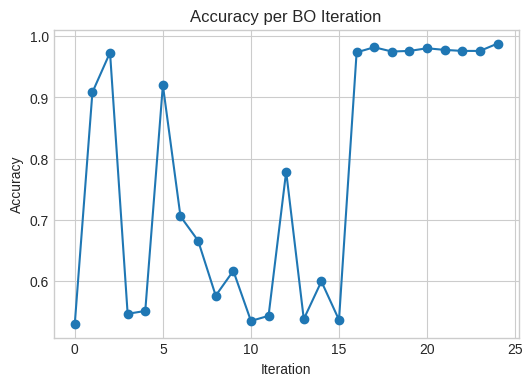

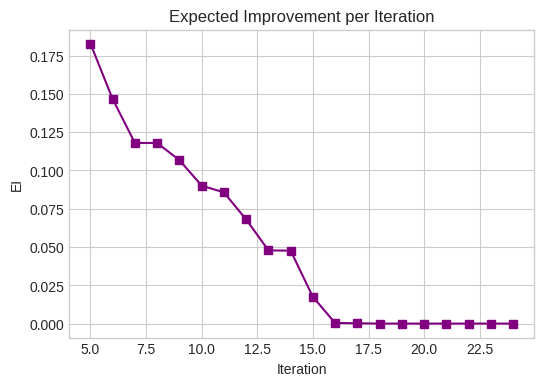

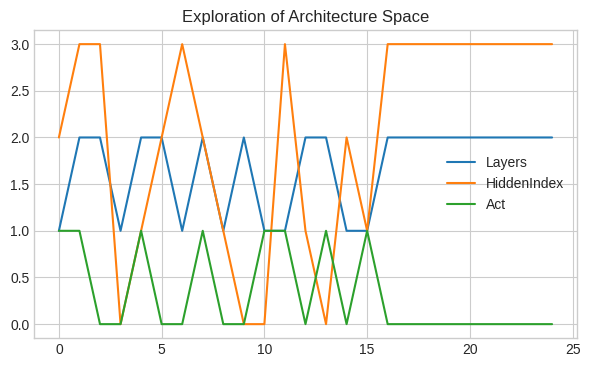

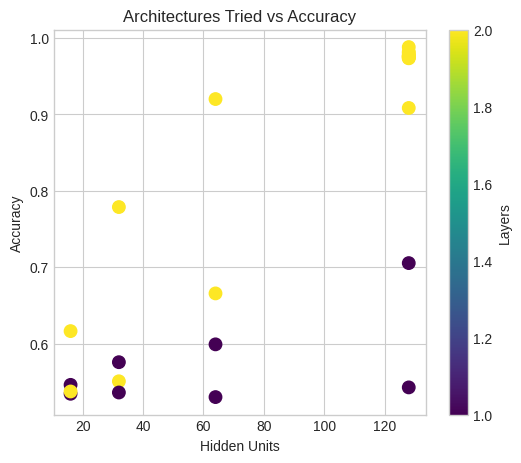

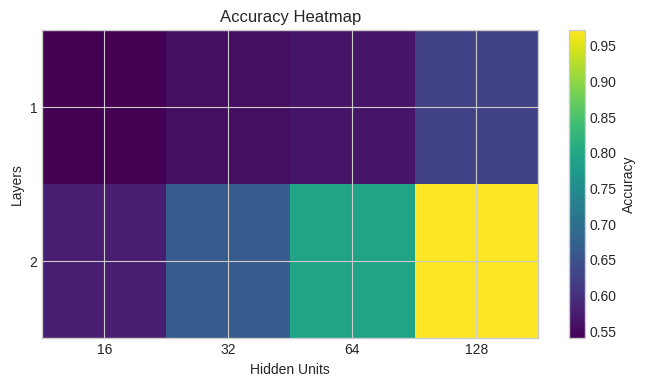

In [ ]:
# ============================================================
# BAYESIAN OPTIMIZATION NAS (Discreet Architecture Search)
# Gaussian Process + Expected Improvement
# Zero external dependencies besides numpy, torch, matplotlib
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# ------------------------------------------------------------
# 1. SPIRAL DATASET
# ------------------------------------------------------------
def generate_spiral(n_points, n_classes=3):
    X = np.zeros((n_points*n_classes, 2))
    y = np.zeros(n_points*n_classes, dtype='int')

    for j in range(n_classes):
        ix = range(n_points*j, n_points*(j+1))
        r = np.linspace(0.0, 1, n_points)
        t = np.linspace(j*4, (j+1)*4, n_points) + np.random.randn(n_points)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    return X, y

# create dataset
X_np, y_np = generate_spiral(1000)
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long)
loader = DataLoader(TensorDataset(X, y), batch_size=128, shuffle=True)

# ------------------------------------------------------------
# 2. MODEL + TRAINER
# ------------------------------------------------------------
def build_model(num_layers, hidden, act):
    act_fn = nn.ReLU() if act == 0 else nn.Tanh()
    layers = [nn.Linear(2, hidden), act_fn]

    for _ in range(num_layers - 1):
        layers.append(nn.Linear(hidden, hidden))
        layers.append(act_fn)

    layers.append(nn.Linear(hidden, 3))
    return nn.Sequential(*layers)

def train_classifier(model, epochs=12, lr=1e-3):
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(epochs):
        for xb, yb in loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

    with torch.no_grad():
        preds = model(X).argmax(dim=1).numpy()
    acc = accuracy_score(y_np, preds)
    return acc

# ------------------------------------------------------------
# 3. SEARCH SPACE
# ------------------------------------------------------------
L_choices = [1,2]
H_choices = [16,32,64,128]
A_choices = [0,1]

def decode(x):
    L = L_choices[int(x[0])]
    H = H_choices[int(x[1])]
    A = A_choices[int(x[2])]
    return L, H, A

# All possible architectures
grid = []
for i in range(len(L_choices)):
    for j in range(len(H_choices)):
        for k in range(len(A_choices)):
            grid.append([i,j,k])
grid = np.array(grid)   # shape (30,3)

# ------------------------------------------------------------
# 4. GAUSSIAN PROCESS (from scratch)
# ------------------------------------------------------------
def rbf_kernel(X1, X2, length=1.0, sigma_f=1.0):
    sqdist = (
        np.sum(X1**2, axis=1).reshape(-1,1)
        + np.sum(X2**2, axis=1)
        - 2*np.dot(X1, X2.T)
    )
    return sigma_f**2 * np.exp(-0.5/length**2 * sqdist)

class GaussianProcess:
    def __init__(self, noise=1e-6, length=1.0, sigma_f=1.0):
        self.noise=noise
        self.length=length
        self.sigma_f=sigma_f

    def fit(self, X, y):
        self.X = X
        self.y = y
        K = rbf_kernel(X, X, self.length, self.sigma_f) + self.noise*np.eye(len(X))
        self.K_inv = np.linalg.inv(K)

    def predict(self, Xs):
        K_s = rbf_kernel(self.X, Xs, self.length, self.sigma_f)
        K_ss = rbf_kernel(Xs, Xs, self.length, self.sigma_f) + 1e-8*np.eye(len(Xs))
        mu = K_s.T.dot(self.K_inv).dot(self.y)
        cov = K_ss - K_s.T.dot(self.K_inv).dot(K_s)
        return mu, np.clip(np.diag(cov), 1e-8, 1e10)

# ------------------------------------------------------------
# 5. Expected Improvement
# ------------------------------------------------------------
def expected_improvement(mu, sigma, best):
    sigma = np.maximum(sigma, 1e-12)
    z = (mu - best) / sigma
    # Normal CDF and PDF
    phi = 1/np.sqrt(2*np.pi) * np.exp(-0.5*z*z)
    Phi = 0.5*(1 + torch.erf(torch.tensor(z/np.sqrt(2.0))).numpy())
    return (mu - best)*Phi + sigma*phi

# ------------------------------------------------------------
# 6. FULL BO-NAS LOOP (Tracks everything)
# ------------------------------------------------------------
def bo_nas(iterations=20):

    X_obs=[]
    y_obs=[]

    # Tracking info
    acc_hist=[]
    arch_hist=[]
    ei_hist=[]

    # -------- initial random samples --------
    init_samples = 5
    for _ in range(init_samples):
        idx = np.random.randint(len(grid))
        arch = grid[idx]
        L, H, A = decode(arch)
        acc = train_classifier(build_model(L,H,A))
        print(f"[INIT] L={L}, H={H}, A={A}, acc={acc:.4f}")

        X_obs.append(arch)
        y_obs.append(acc)
        acc_hist.append(acc)
        arch_hist.append((L,H,A))
        ei_hist.append(None)

    X_obs = np.array(X_obs)
    y_obs = np.array(y_obs)

    # -------- BO iterations --------
    for it in range(iterations):
        gp = GaussianProcess()
        gp.fit(X_obs, y_obs)

        mu, var = gp.predict(grid)
        sigma = np.sqrt(var)
        best_so_far = max(y_obs)

        ei = expected_improvement(mu, sigma, best_so_far)
        next_idx = np.argmax(ei)
        next_arch = grid[next_idx]

        L, H, A = decode(next_arch)
        acc = train_classifier(build_model(L,H,A))

        print(f"[ITER {it:02d}] L={L}, H={H}, A={A}, acc={acc:.4f}")

        X_obs = np.vstack([X_obs, next_arch])
        y_obs = np.append(y_obs, acc)

        acc_hist.append(acc)
        arch_hist.append((L,H,A))
        ei_hist.append(ei[next_idx])

    best_idx = np.argmax(y_obs)
    return decode(X_obs[best_idx]), y_obs[best_idx], acc_hist, arch_hist, ei_hist

# ------------------------------------------------------------
# 7. PLOTTING UTILITIES
# ------------------------------------------------------------
def plot_accuracy_curve(acc):
    plt.figure(figsize=(6,4))
    plt.plot(acc, marker='o')
    plt.title("Accuracy per BO Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

def plot_ei_curve(ei_hist):
    plt.figure(figsize=(6,4))
    vals = [v if v is not None else np.nan for v in ei_hist]
    plt.plot(vals, marker='s', color='purple')
    plt.title("Expected Improvement per Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("EI")
    plt.grid(True)
    plt.show()

def plot_architecture_exploration(arch_hist):
    num = []
    for L,H,A in arch_hist:
        num.append([L, [16,32,64,128].index(H), A])
    num = np.array(num)

    plt.figure(figsize=(7,4))
    plt.plot(num)
    plt.legend(["Layers","HiddenIndex","Act"])
    plt.title("Exploration of Architecture Space")
    plt.grid(True)
    plt.show()

def plot_architecture_vs_accuracy(arch_hist, acc_hist):
    layers = np.array([a[0] for a in arch_hist])
    hidden = np.array([a[1] for a in arch_hist])
    plt.figure(figsize=(6,5))
    sc = plt.scatter(hidden, acc_hist, c=layers, cmap='viridis', s=80)
    plt.colorbar(sc, label="Layers")
    plt.xlabel("Hidden Units")
    plt.ylabel("Accuracy")
    plt.title("Architectures Tried vs Accuracy")
    plt.grid(True)
    plt.show()

def plot_heatmap(arch_hist, acc_hist):
    Lch = [1,2]
    Hch = [16,32,64,128]

    heat = np.zeros((len(Lch), len(Hch)))
    count = np.zeros_like(heat)

    for (L,H,A),acc in zip(arch_hist, acc_hist):
        i = Lch.index(L)
        j = Hch.index(H)
        heat[i,j]+=acc
        count[i,j]+=1

    avg = heat / np.maximum(count, 1e-6)

    plt.figure(figsize=(8,4))
    plt.imshow(avg, cmap='viridis', aspect='auto')
    plt.colorbar(label="Accuracy")
    plt.xticks(range(len(Hch)), Hch)
    plt.yticks(range(len(Lch)), Lch)
    plt.xlabel("Hidden Units")
    plt.ylabel("Layers")
    plt.title("Accuracy Heatmap")
    plt.show()

# ------------------------------------------------------------
# 8. RUN EVERYTHING
# ------------------------------------------------------------
best_arch, best_acc, acc_hist, arch_hist, ei_hist = bo_nas(iterations=20)

print("\n=== BEST ARCHITECTURE FOUND ===")
print(best_arch)
print("Accuracy:", best_acc)

# PLOTS
plot_accuracy_curve(acc_hist)
plot_ei_curve(ei_hist)
plot_architecture_exploration(arch_hist)
plot_architecture_vs_accuracy(arch_hist, acc_hist)
plot_heatmap(arch_hist, acc_hist)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_decision_boundary(model, X, y, h=0.01):
    # Convert X to numpy
    X_np = X.numpy()

    # Create a meshgrid
    x_min, x_max = X_np[:,0].min() - 0.1, X_np[:,0].max() + 0.1
    y_min, y_max = X_np[:,1].min() - 0.1, X_np[:,1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Flatten and convert to torch
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # Predict on the grid
    with torch.no_grad():
        Z = model(grid).argmax(dim=1).numpy()

    # Reshape predictions back to meshgrid shape
    Z = Z.reshape(xx.shape)

    # Plot contour
    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.rainbow)

    # Plot original data points
    plt.scatter(X_np[:,0], X_np[:,1], c=y.numpy(), s=30, cmap=plt.cm.rainbow, edgecolor='k')
    plt.title("Decision Boundary of BO-NAS Best Architecture")
    plt.show()


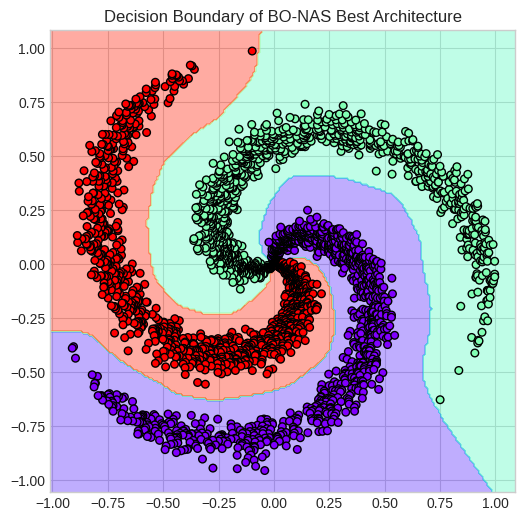

In [ ]:
# Suppose these come from the BO-NAS run
# best_arch, best_acc, acc_hist, arch_hist, ei_hist
# Example:
# best_arch = (3, 128, 0)  # layers, hidden units, activation

# Build the best model
L, H, A = best_arch
best_model = build_model(L, H, A)

# Train it fully
train_classifier(best_model, epochs=50, lr=1e-3)

# Plot decision boundary
plot_decision_boundary(best_model, X, y)
